In [15]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random
import glob
import os
import re

import utilities as ut
import modularised_utils as mut
from load_results import load_results, list_available_results


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

In [16]:
list_available_results()

Found 2 evaluation result files:
 1. LILUCAS
    File: evaluation_additive_gaussian_alpha10-0.0-1.0_noise25-0.0-10.0_trials20_zero_meanTrue_20250724_174901.csv
    Size: 11905.9 KB | Created: 2025-07-24 17:49:01
    Parameters:
      - Shift: additive | Distribution: gaussian
      - Alpha: 10 steps (0.0 to 1.0)
      - Noise: 25 steps (0.0 to 10.0)
      - Trials: 20 | Zero mean: True

 2. SLC
    File: evaluation_additive_gaussian_alpha10-0.0-1.0_noise25-0.0-5.0_trials20_zero_meanTrue_20250724_162709.csv
    Size: 12028.3 KB | Created: 2025-07-24 16:27:10
    Parameters:
      - Shift: additive | Distribution: gaussian
      - Alpha: 10 steps (0.0 to 1.0)
      - Noise: 25 steps (0.0 to 5.0)
      - Trials: 20 | Zero mean: True



['data/lilucas/evaluation_results/evaluation_additive_gaussian_alpha10-0.0-1.0_noise25-0.0-10.0_trials20_zero_meanTrue_20250724_174901.csv',
 'data/slc/evaluation_results/evaluation_additive_gaussian_alpha10-0.0-1.0_noise25-0.0-5.0_trials20_zero_meanTrue_20250724_162709.csv']

In [17]:
experiment = 'lilucas'
path = f"data/{experiment}/results"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'lilucas'.


In [21]:
final_results_df = load_results(
                                experiment=experiment,
                                shift_type='additive',
                                distribution='gaussian',
                                alpha_steps=10,
                                alpha_min=0.0,
                                alpha_max=1.0,
                                noise_steps=25,
                                noise_min=0.0,
                                noise_max=10.0,
                                trials=20,
                                zero_mean=True
                            )


Loading: evaluation_additive_gaussian_alpha10-0.0-1.0_noise25-0.0-10.0_trials20_zero_meanTrue_20250724_174901.csv
Parameters: additive gaussian, α: 10 steps (0.0-1.0), noise: 25 steps (0.0-10.0), trials: 20, zero_mean: True


### 0-shift

In [22]:
df_clean             = final_results_df[final_results_df['alpha']==0.0]
summary_stats        = df_clean.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])

print("--- Final Summary (Mean Error ± SEM) ---")

# 2. Now, print the results in your custom table format
print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean Error ± Standard Error of Mean (SEM)'}")
print("="*65)

# The 'method' is now in the index of the summary table
for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    # The method_name from the index is already the clean display name
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)

--- Final Summary (Mean Error ± SEM) ---

Method/Run                                    | Mean Error ± Standard Error of Mean (SEM)
BARYCA                                        |  7.5448 ± 0.0002
DIROCA (eps_delta_0.111)                      |  7.3967 ± 0.0004
DIROCA (eps_delta_1)                          |  7.7972 ± 0.0006
DIROCA (eps_delta_2)                          |  7.6567 ± 0.0007
DIROCA (eps_delta_4)                          |  8.1671 ± 0.0007
DIROCA (eps_delta_8)                          |  8.7413 ± 0.0004
GradCA                                        | 12.2711 ± 0.0014


### Point comparison

In [23]:
alpha_point = 1.0
noise_level_point = 10.0

df_point            = final_results_df[(final_results_df['alpha']==alpha_point) & (final_results_df['noise_scale']==noise_level_point)]
summary_stats        = df_point.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])

print("--- Final Summary (Mean Error ± SEM) ---")

# 2. Now, print the results in your custom table format
print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean Error ± Standard Error of Mean (SEM)'}")
print("="*65)

# The 'method' is now in the index of the summary table
for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    # The method_name from the index is already the clean display name
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)

--- Final Summary (Mean Error ± SEM) ---

Method/Run                                    | Mean Error ± Standard Error of Mean (SEM)
BARYCA                                        | 80.4449 ± 0.0301
DIROCA (eps_delta_0.111)                      | 90.9190 ± 0.0319
DIROCA (eps_delta_1)                          | 42.8429 ± 0.0155
DIROCA (eps_delta_2)                          | 38.6557 ± 0.0158
DIROCA (eps_delta_4)                          | 12.4977 ± 0.0079
DIROCA (eps_delta_8)                          | 12.4436 ± 0.0091
GradCA                                        | 100.0639 ± 0.0400


### Fix/vary curves

In [24]:
label_map = {
    'DIROCA (eps_delta_0.111)': r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$',
    'DIROCA (eps_delta_1)':     r'DiRoCA$_{1,1}$',
    'DIROCA (eps_delta_2)':     r'DiRoCA$_{2,2}$',
    'DIROCA (eps_delta_4)':     r'DiRoCA$_{4,4}$',
    'DIROCA (eps_delta_8)':     r'DiRoCA$_{8,8}$',
    'GradCA':                   r'GRAD$_{(\tau, \omega)}$',
    'BARYCA':                   r'GRAD$_{\text{bary}}$',
    'Abs-LiNGAM (Perfect)':     r'AbsLin$_{\text{p}}$', 
    'Abs-LiNGAM (Noisy)':       r'AbsLin$_{\text{n}}$'
}

### Fix alpha

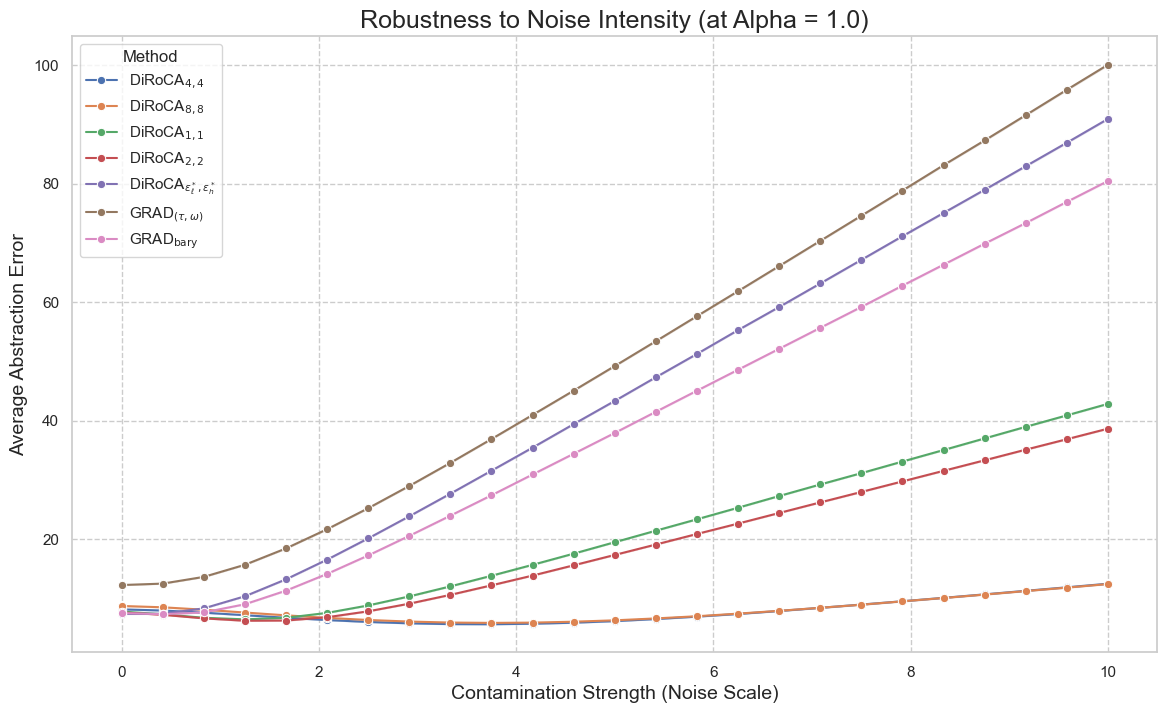

In [25]:
alpha_to_plot = 1.0

df_subset = final_results_df[final_results_df['alpha'] == alpha_to_plot]

if df_subset.empty:
    print(f"Warning: No data found for alpha ≈ {alpha_to_plot}. Please check the 'alpha_values' in your experiment.")
else:
    df_for_plotting = df_subset.copy()
    df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=df_for_plotting,
        x='noise_scale',
        y='error',
        hue='display_name',
        marker='o',
        linewidth=1.5,
        errorbar=('ci', 95) # Shaded area is the 95% CI across folds and trials
    )
    plt.title(f'Robustness to Noise Intensity (at Alpha = {alpha_to_plot})', fontsize=18)
    plt.xlabel('Contamination Strength (Noise Scale)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

In [26]:
alpha_values = sorted(final_results_df['alpha'].unique())

df_for_plotting = final_results_df.copy()
df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)


fig, ax = plt.subplots(figsize=(14, 8))
y_max   = final_results_df['error'].max()


def update_alpha(alpha):
    ax.clear() # Clear the previous frame
    
    # Filter the data for the current alpha value
    df_subset = df_for_plotting[np.isclose(df_for_plotting['alpha'], alpha)]
    
    # Draw the lineplot for this frame
    sns.lineplot(
        data=df_subset,
        x='noise_scale',
        y='error',
        hue='display_name',
        marker='o',
        errorbar=('ci', 95),
        ax=ax
    )
    
    ax.set_title(f'Robustness to Noise Intensity (at Alpha = {alpha:.2f})', fontsize=18)
    ax.set_xlabel('Contamination Strength (Noise Scale)', fontsize=14)
    ax.set_ylabel('Average Abstraction Error', fontsize=14)
    ax.legend(title='Method')
    ax.grid(True, which='both', linestyle='--')
    ax.set_ylim(0, y_max * 1.1) # Keep y-axis consistent


print("Creating animation for evolving alpha...")
ani_alpha = FuncAnimation(fig, update_alpha, frames=alpha_values, blit=False, repeat=False)

# Save the GIF
ani_alpha.save('robustness_vs_noise_evolving_alpha.gif', writer='pillow', fps=2)
plt.close() # Prevent the final static plot from showing

print("✓ Animation saved as 'robustness_vs_noise_evolving_alpha.gif'")
# HTML(ani_alpha.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating animation for evolving alpha...
✓ Animation saved as 'robustness_vs_noise_evolving_alpha.gif'


### Fix Noise

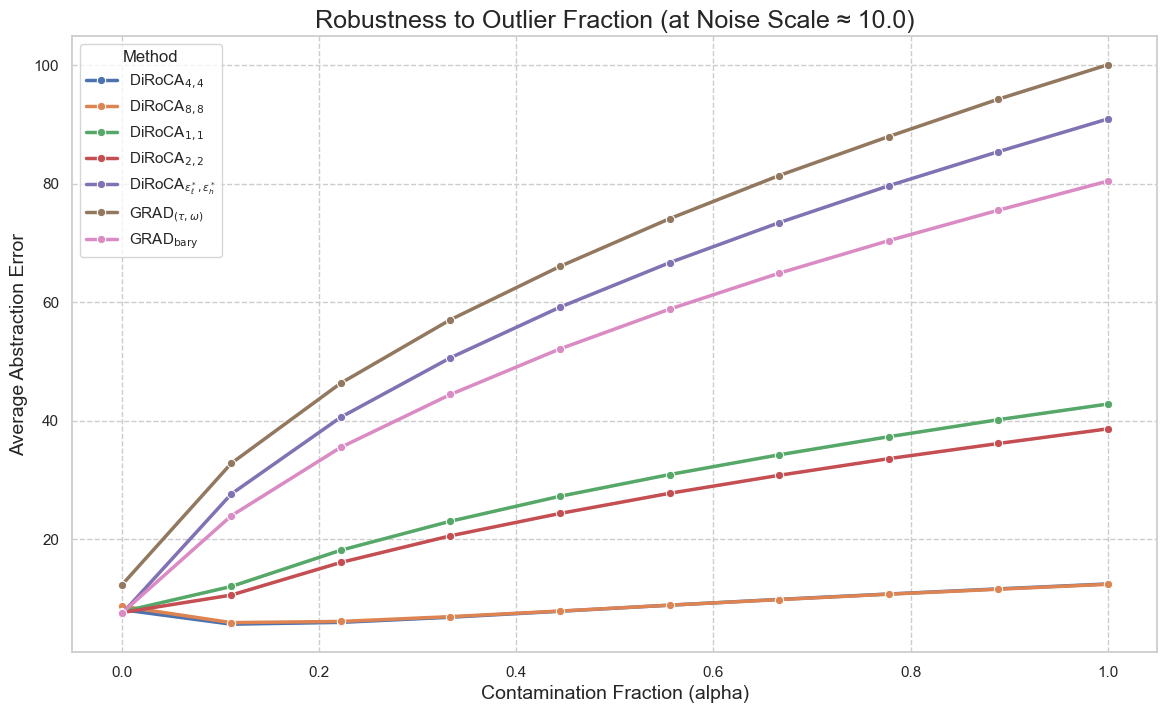

In [27]:
noise_level_to_plot = 10.0

df_subset = final_results_df[final_results_df['noise_scale'] == noise_level_to_plot]

if df_subset.empty:
    print(f"Warning: No data found for noise_scale ≈ {noise_level_to_plot}.")
else:
    df_for_plotting = df_subset.copy()
    df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=df_for_plotting,
        x='alpha',
        y='error',
        hue='display_name',
        marker='o',
        linewidth=2.5,
        errorbar=('ci', 95)
    )

    plt.title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {noise_level_to_plot})', fontsize=18)
    plt.xlabel('Contamination Fraction (alpha)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

In [28]:
noise_levels = sorted(final_results_df['noise_scale'].unique())

df_for_plotting = final_results_df.copy()
df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

fig, ax = plt.subplots(figsize=(14, 8))
y_max = final_results_df['error'].max()

def update_noise(scale):
    ax.clear()
    
    # Filter the data for the current noise scale
    df_subset = df_for_plotting[np.isclose(df_for_plotting['noise_scale'], scale)]
    
    # Draw the lineplot for this frame
    sns.lineplot(
        data=df_subset,
        x='alpha',
        y='error',
        hue='display_name',
        marker='o',
        errorbar=('ci', 95),
        ax=ax
    )
    
    ax.set_title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {scale:.2f})', fontsize=18)
    ax.set_xlabel('Contamination Fraction (alpha)', fontsize=14)
    ax.set_ylabel('Average Abstraction Error', fontsize=14)
    ax.legend(title='Method')
    ax.grid(True, which='both', linestyle='--')
    ax.set_ylim(0, y_max * 1.1)


print("Creating animation for evolving noise scale...")
ani_noise = FuncAnimation(fig, update_noise, frames=noise_levels, blit=False, repeat=False)

# Save the GIF
ani_noise.save('robustness_vs_alpha_evolving_noise.gif', writer='pillow', fps=2)
plt.close()

print("✓ Animation saved as 'robustness_vs_alpha_evolving_noise.gif'")
# HTML(ani_noise.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating animation for evolving noise scale...
✓ Animation saved as 'robustness_vs_alpha_evolving_noise.gif'
